# Lanczos and MINRES

When $A^*=A$, a number of things about iterative methods get better and faster. The most notable development is that the Hessenberg matrix $H_n$ is also hermitian and thus tridiagonal. Consequently the Arnoldi iteration's loop to fill in $H$ becomes a fixed length process, greatly speeding up the computation as the dimension of $\mathcal{K}_n$ increases. The result is known as the _Lanczos iteration_.

Here once again is the standard Arnoldi iteration. 

In [5]:
using LinearAlgebra,PyPlot

function arnoldi(A,nmax)
    m = size(A,1)
    Q = zeros(m,nmax+1);
    H = zeros(nmax+1,nmax);
    b = randn(m)
    Q[:,1] = b/norm(b);
    for n = 1:nmax
        v = A*Q[:,n]
        for i = 1:n
            H[i,n] = Q[:,i]'*v
            v = v - H[i,n]*Q[:,i]
        end
        H[n+1,n] = norm(v);
        Q[:,n+1] = v/H[n+1,n];
    end
    return H,Q
end

arnoldi (generic function with 1 method)

We could just run this as is, and the resulting $H_n$ will be (numerically) tridiagonal. But we can speed things up to exploit the symmetry just by tweaking the limits of the inner loop.

In [9]:
function lanczos(A,nmax)
    m = size(A,1)
    Q = zeros(eltype(A),m,nmax+1);
    H = zeros(eltype(A),nmax+1,nmax);
    b = randn(m)
    Q[:,1] = b/norm(b);
    for n = 1:nmax
        v = A*Q[:,n]
        for i = max(1,n-1):n
            H[i,n] = Q[:,i]'*v
            v = v - H[i,n]*Q[:,i]
        end
        H[n+1,n] = norm(v);
        Q[:,n+1] = v/H[n+1,n];
    end
    return H,Q
end

lanczos (generic function with 1 method)

Surprisingly, we get the full behavior just by considering diagonal matrices. (The tridiagonal matrix is invariant with respect to orthogonal similarity.) Lanczos doesn't "know" the matrix is diagonal. 

In [11]:
m = 400;
kappa = 10;
N = 60;
lam = range(1,stop=kappa,length=m)
A = Diagonal(lam);
T,Q = lanczos(A,N);
T[1:5,1:5]

5×5 Array{Float64,2}:
 5.65684  2.64158  0.0      0.0      0.0    
 2.64158  5.47942  2.28213  0.0      0.0    
 0.0      2.28213  5.37503  2.29984  0.0    
 0.0      0.0      2.29984  5.38894  2.34185
 0.0      0.0      0.0      2.34185  5.44413

The variant of GMRES specialized to the hermitian case is called **MINRES**. 

In [12]:
function minres(A,b,nmax)
    m = size(A,1)
    Q = zeros(eltype(A),m,nmax+1);
    H = zeros(eltype(A),nmax+1,nmax);
    nrmb = norm(b)
    Q[:,1] = b/nrmb
    resnorm = zeros(nmax)
    for n = 1:nmax
        v = A*Q[:,n]
        for i = max(1,n-1):n
            H[i,n] = Q[:,i]'*v
            v = v - H[i,n]*Q[:,i]
        end
        H[n+1,n] = norm(v);
        Q[:,n+1] = v/H[n+1,n];
        
        Qtb = [nrmb;zeros(n)]
        global z = H[1:n+1,1:n] \ Qtb
        resnorm[n] = norm( H[1:n+1,1:n]*z - Qtb ) / nrmb
    end
    x = Q[:,1:nmax]*z
    return x,resnorm
end

minres (generic function with 1 method)

The analog of GMRES in the hermitian case is MINRES, which solves the same least-squares problem on top of the Lanczos iteration. In the case (as here) of a positive definite $A$, there is a convenient theoretical bound on the convergence:

$$ \frac{\|r_n\|}{\|r_0\|} \le 2 \left( \frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1} \right)^n,$$

where $\kappa=\kappa_2(A)$ equals the ratio of max to min eigenvalues.

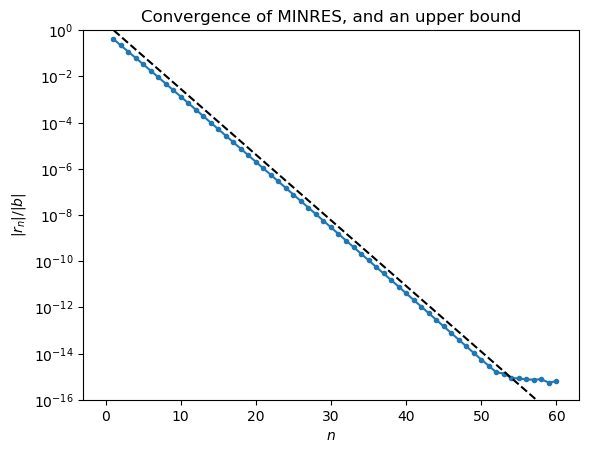

In [13]:
b = ones(m)
x,resnorm = minres(A,b,N)
semilogy(1:N,resnorm,".-")

bound = 2*( (sqrt(kappa)-1)/(sqrt(kappa)+1) ).^(0:N);
semilogy(0:N,bound,"k--");

ylim(1e-16,1);
xlabel(L"n"), ylabel(L"\|r_n\|/\|b\|");
title("Convergence of MINRES, and an upper bound");

Things are a lot slower in the indefinite symmetric case. 

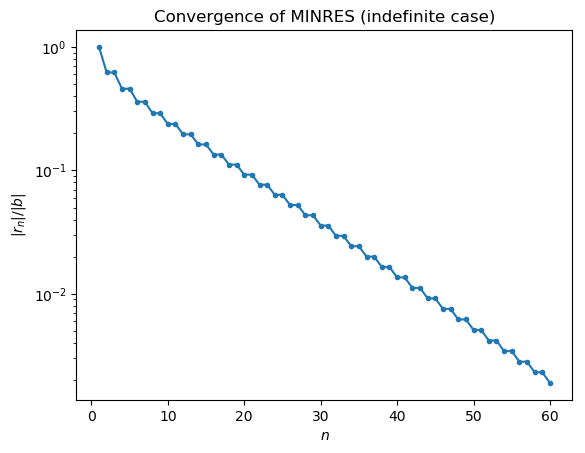

In [21]:
lam = range(1,stop=kappa,length=m÷2)
A = Diagonal([-lam;lam])
x,resnorm = minres(A,b,N)
semilogy(1:N,resnorm,".-")

xlabel(L"n"), ylabel(L"\|r_n\|/\|b\|");
title("Convergence of MINRES (indefinite case)");